In [1]:
import math

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import torch
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path
import re
import itertools

from SIREN_utils import (
    plot_complex_matrix,
    get_interpolated_matrix,
    fold_OP_mat,
    unfold_OP_mat,
    get_diagonal_line,
    reformat_diagonal,
    extract_diagonals,
    reformat_matrix_from_diagonals,
    get_V_coords,
    check_D4_symmetries
)

In [2]:
plt.style.use(["science", "notebook", "grid"])

In [3]:
# state variables
U=1
error_c='2e-5'
label = f"U_{U}_ground_state"

In [4]:
# helper function to convert an MxM matrix into a sequence of flattened vectors
def make_2x2_matrices(array: np.ndarray, data_dict: dict) -> np.ndarray:
    # array should be of shape (2L^2, 2L^2)
    m_dim = 2

    # first we need to find L
    two_L_square = array.shape[0]
    L_square = two_L_square // m_dim
    L = int(round(math.sqrt(L_square)))

    # flatten alpha indices
    folded_array = fold_OP_mat(array)  # should be of shape (L^2, L^2, 2, 2)

    # get diagonal matrices
    diag_list = extract_diagonals(folded_array)

    # reshape them for the NN
    new_list = []
    for index, diag in enumerate(diag_list):
        diag_indices = data_dict[f"diag_{index+1}"]
        for i, j in diag_indices:
            new_list.append(diag[:, :, i, j].reshape((L**2)))

    new_list = np.stack(new_list, axis=-1)
    return new_list

In [5]:
def get_indices_dict(OP_mat: np.ndarray) -> dict:
    data_dict = {}

    # for both central and off- diagonals:
    for index, diag in enumerate(extract_diagonals(fold_OP_mat(OP_mat))):
        diag_indices = []

        # iterate over the 2x2 matrix
        for i, j in itertools.product((0, 1), repeat=2):
            # check if empty
            diagonal_matrix = diag[:, :, i, j]
            if np.max(np.abs(diagonal_matrix)) > 0.1:
                diag_indices.append((i, j))
        
        data_dict[f"diag_{index+1}"] = diag_indices
    return data_dict

In [6]:
def get_OP_dataset(L, pattern_representative):
    # pattern representative should be of shape (2L_rep^2, 2L_rep^2)
    L_rep = int(round(math.sqrt(pattern_representative.shape[0] / 2)))

    data_dict = get_indices_dict(pattern_representative)

    pattern = re.compile(rf"^L_{L}_U_{U}_number_of_random_initials_(\d+)_occupied_{int(((L ** 2) / 2))}_{int(((L ** 2) / 2))}__index_(\d+)_new$")
    base_dir = Path(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}")

    # find the lowest energy
    min_energy = float("inf")
    reference_OP = None
    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            results_filename = folder / "P_HF_result.h5"
            with h5py.File(results_filename, 'r') as results_file:
                num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                for i in range(1, num_samples + 1):
                    try:
                        # find the energy
                        energy = (
                            results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                        )
                    except KeyError:
                        continue

                    if energy - min_energy < 1e-4:
                        # get the OP for this initial
                        results_OP = np.transpose(
                            results_file[f"P_HF_result_{i}"][()]
                        ).conj()

                        # check interpolation
                        test_OP = get_interpolated_matrix(results_OP, L_rep)
                        max_abs = np.max(np.abs(test_OP - pattern_representative))
                        if max_abs < 0.3:  # means it has the same pattern
                            reference_OP = results_OP

                        if energy < min_energy:
                            min_energy = energy

    print(f"Minimum Energy: {min_energy}")

    sequence_list = []

    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            with h5py.File(folder / "P_HF_initial.h5", 'r') as initials_file:
                with h5py.File(folder / "P_HF_result.h5", 'r') as results_file:
                    num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                    for i in range(1, num_samples + 1):
                        print(f"\rIndex: {i}", end="", flush=True)
                        try:
                            # check if its in the lowest energy band and matches the pattern
                            energy = (
                                results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                            )
                            if energy - min_energy < 1e-4:
                                results_OP = np.transpose(
                                    results_file[f"P_HF_result_{i}"][()]
                                ).conj()

                                if np.max(np.abs(results_OP - reference_OP)) < 0.01:
                                    initial_OP = np.transpose(
                                        initials_file[f"P_initial_{i}"][()]
                                    ).conj()

                                    sequence_list.append(
                                        np.array(
                                            [
                                                make_2x2_matrices(initial_OP, data_dict),
                                                make_2x2_matrices(results_OP, data_dict),
                                            ]
                                        )
                                    )
                        except KeyError:
                            continue

    sequence_list = np.array(sequence_list, dtype=np.float32)

    # randomly shuffle the combined dataset
    rng = np.random.default_rng()
    rng.shuffle(sequence_list, axis=0)

    # now save to file
    with h5py.File(
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/{label}/{error_c}/hubbard_model_lowest_energy_{L}x{L}_{label}.h5",
        "w",
    ) as dataset_file:
        dataset_file.create_dataset(
            name="dataset", data=sequence_list, dtype=np.float32
        )

    print(f"\nFinal shape: {sequence_list.shape}")
    print(f"Data type: {sequence_list.dtype}")

    return reference_OP

In [7]:
def get_best_OP_mat(L: int, base_dir = f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}"):
    pattern = re.compile(rf"^L_{L}_U_{U}_number_of_random_initials_(\d+)_occupied_{int(((L ** 2) / 2))}_{int(((L ** 2) / 2))}__index_(\d+)_new$")

    base_dir = Path(base_dir)

    # get the OP with the lowest energy
    min_energy = float("inf")
    best_OP = None

    # iterate over all the folders
    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            results_filename = folder / "P_HF_result.h5"
            with h5py.File(results_filename, 'r') as results_file:
                num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                for i in range(1, num_samples + 1):
                    try:
                        energy = (
                            results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                        )
                        if energy < min_energy:
                            min_energy = energy
                            best_OP = np.transpose(
                                results_file[f"P_HF_result_{i}"][()]
                            ).conj()
                    except KeyError:
                        continue

    print(f"Minimum Energy: {min_energy}")
    return best_OP

Minimum Energy: -0.5655885472944004
Minimum Energy: -0.5677032720970541


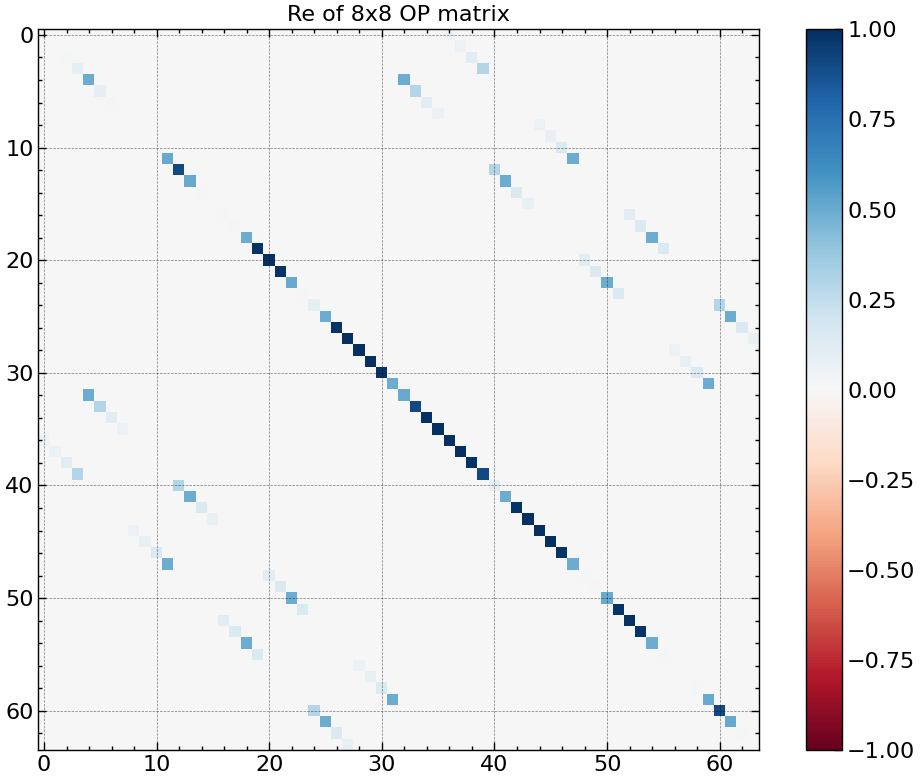

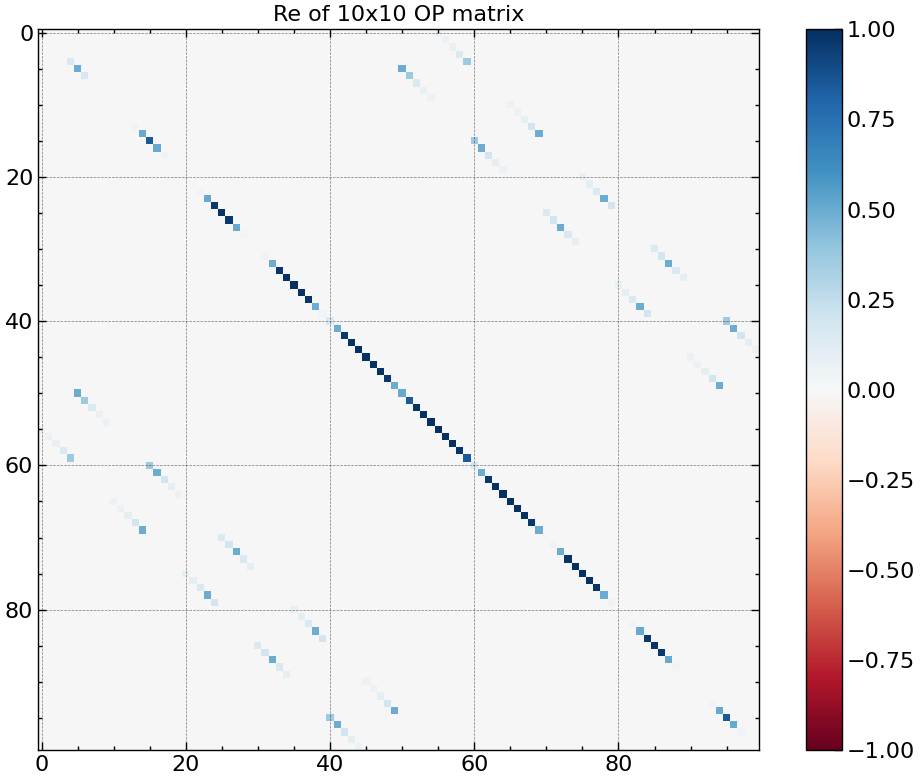

In [8]:
OP_8x8 = get_best_OP_mat(L=8)
OP_10x10 = get_best_OP_mat(L=10)
plot_complex_matrix(fold_OP_mat(OP_8x8)[:, :, 1, 1], title="8x8 OP matrix")
plot_complex_matrix(fold_OP_mat(OP_10x10)[:, :, 1, 1], title="10x10 OP matrix")

In [9]:
pattern_representative = OP_10x10

# make all the datasets at once
# get_OP_dataset(8, pattern_representative)
# get_OP_dataset(10, pattern_representative)
# get_OP_dataset(18, pattern_representative)
for L in range(12, 31, 2):
    get_OP_dataset(L, pattern_representative)

Minimum Energy: -0.5686087724589162
Index: 100
Final shape: (11, 2, 144, 4)
Data type: float32
Minimum Energy: -0.569016245328222
Index: 100
Final shape: (17, 2, 196, 4)
Data type: float32
Minimum Energy: -0.5692102120772654
Index: 100
Final shape: (27, 2, 256, 4)
Data type: float32
Minimum Energy: -0.5693082717820547
Index: 100
Final shape: (23, 2, 324, 4)
Data type: float32
Minimum Energy: -0.56936030305501
Index: 100
Final shape: (22, 2, 400, 4)
Data type: float32
Minimum Energy: -0.5693889704111538
Index: 100
Final shape: (24, 2, 484, 4)
Data type: float32
Minimum Energy: -0.5694050294045587
Index: 100
Final shape: (16, 2, 576, 4)
Data type: float32
Minimum Energy: -0.5694145716824884
Index: 100
Final shape: (21, 2, 676, 4)
Data type: float32
Minimum Energy: -0.5694195965685885
Index: 100
Final shape: (22, 2, 784, 4)
Data type: float32
Minimum Energy: -0.5694228852452351
Index: 100
Final shape: (16, 2, 900, 4)
Data type: float32


In [10]:
def check_pattern(L: int, pattern_representative: np.ndarray):
    # figure out the indices
    data_dict = get_indices_dict(pattern_representative)

    m_dim = 2

    # load from file
    with h5py.File(
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/hubbard_model/diagonal_datasets/{label}/{error_c}/hubbard_model_lowest_energy_{L}x{L}_{label}.h5",
        "r",
    ) as f:
        tensor = f["dataset"][()][0, 1, :, :]
    
    # separate the diagonals
    diag_1 = tensor[:, :len(data_dict["diag_1"])]
    diag_2 = tensor[:, len(data_dict["diag_1"]):]

    # fill in the full diagonal matrices
    diag_list = []
    for diag_idx, diag in enumerate((diag_1, diag_2)):
        diagonal_tensor = np.zeros((L, L, m_dim, m_dim))
        for list_idx, (i, j) in enumerate(data_dict[f"diag_{diag_idx+1}"]):
            diagonal_tensor[:, :, i, j] = diag[:, list_idx].reshape((L, L))
        diag_list.append(diagonal_tensor)

    return reformat_matrix_from_diagonals(diag_list)


test_8x8 = check_pattern(8, pattern_representative)
test_10x10 = check_pattern(10, pattern_representative)
test_18x18 = check_pattern(18, pattern_representative)

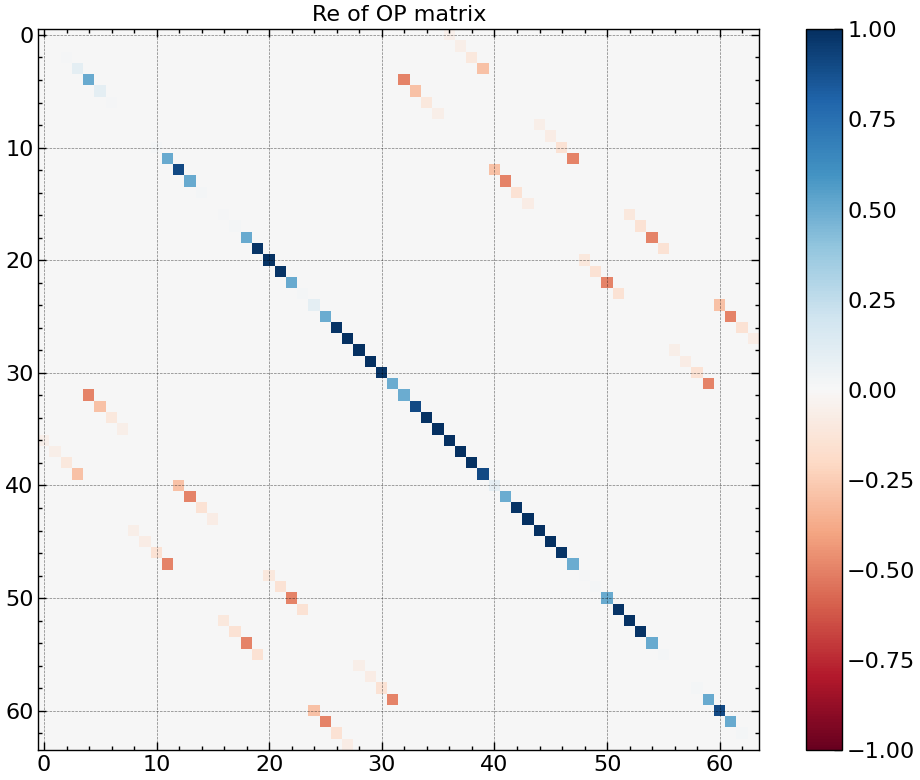

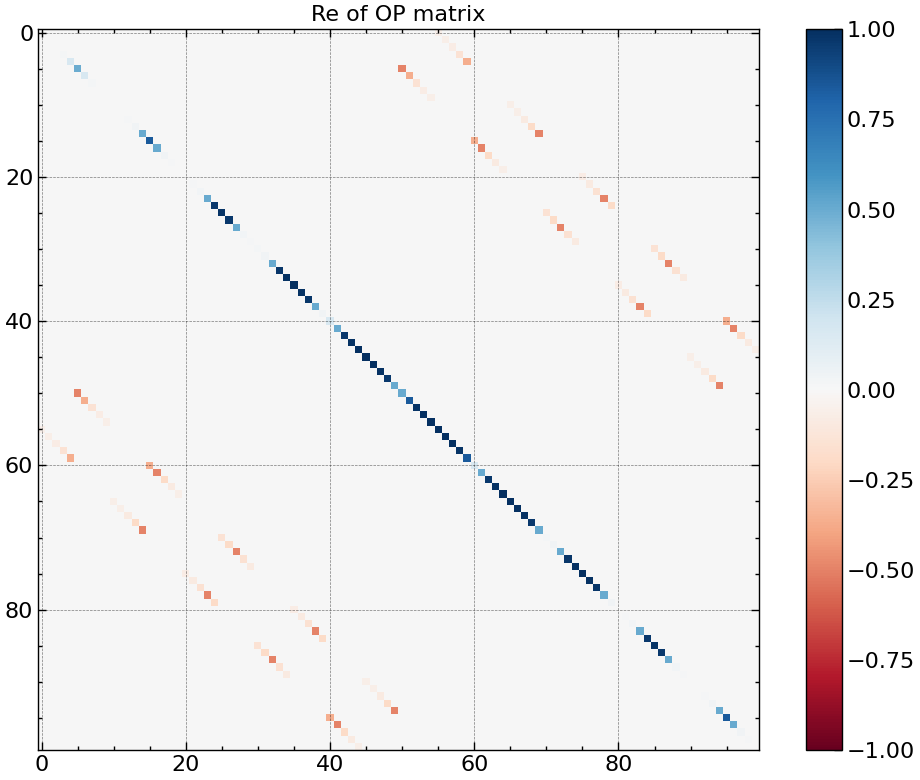

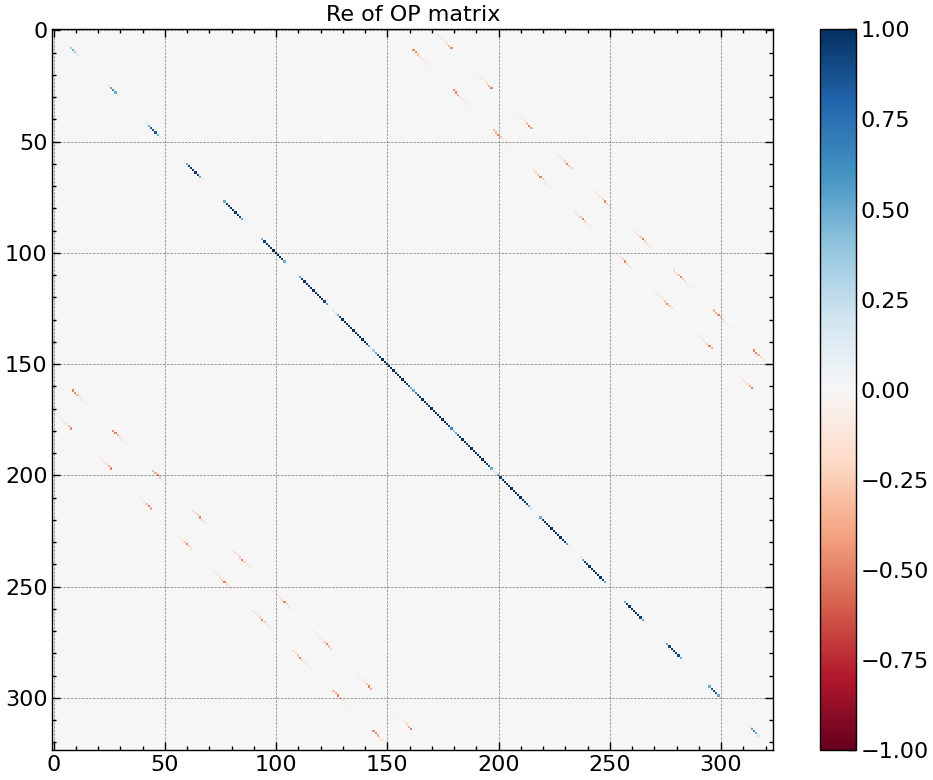

In [11]:
plot_complex_matrix(test_8x8[:, :, 0, 0])
plot_complex_matrix(test_10x10[:, :, 0, 0])
plot_complex_matrix(test_18x18[:, :, 0, 0])

### Plot Energies

In [5]:
def get_energies(L: int, base_dir = f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}"):
    pattern = re.compile(rf"^L_{L}_U_{U}_number_of_random_initials_(\d+)_occupied_{int(((L ** 2) / 2))}_{int(((L ** 2) / 2))}__index_(\d+)_new$")

    base_dir = Path(base_dir)
    energy_list = []

    # iterate over all the folders
    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            results_filename = folder / "P_HF_result.h5"
            with h5py.File(results_filename, 'r') as results_file:
                num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                for i in range(1, num_samples + 1):
                    try:
                        energy = (
                            results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                        )
                        energy_list.append(energy)
                    except KeyError:
                        continue
    
    energy_list = np.array(energy_list)
    return energy_list

In [6]:
energies_8x8 = get_energies(8)
energies_10x10 = get_energies(10)
energies_18x18 = get_energies(18)

In [7]:
def plot_energies(energies: np.ndarray, L: int, U: int):
    domain = np.arange(len(energies))
    min_energy = np.min(energies)
    threshold = 1e-4

    near_min_mask = np.abs(energies - min_energy) < threshold

    plt.figure(figsize=(12, 6))

    plt.scatter(domain[~near_min_mask], energies[~near_min_mask],
                marker='o', c="blue", s=7, label="Other energies")

    plt.scatter(domain[near_min_mask], energies[near_min_mask],
                marker='o', c="red", s=20, label="Within 1e-4 of min")

    plt.title(f"Energies for Hubbard model for $L={L}$, $U={U}$")
    plt.xlabel("Index")
    plt.ylabel("Energy")
    plt.xlim(0, len(energies))

    # Move legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()  # ensures layout adjusts to include legend
    plt.show()

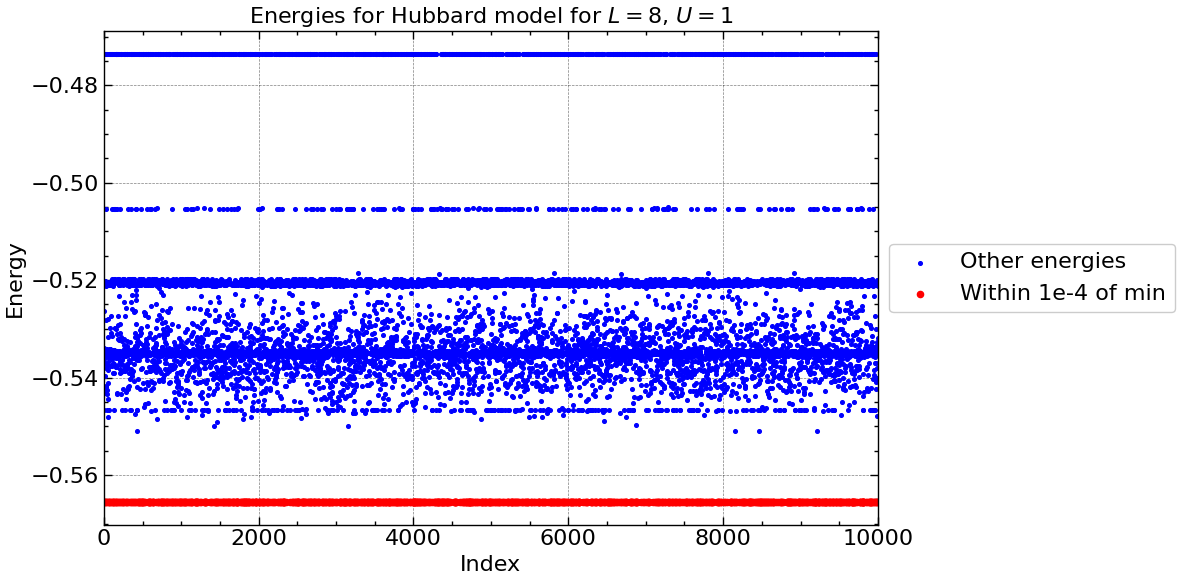

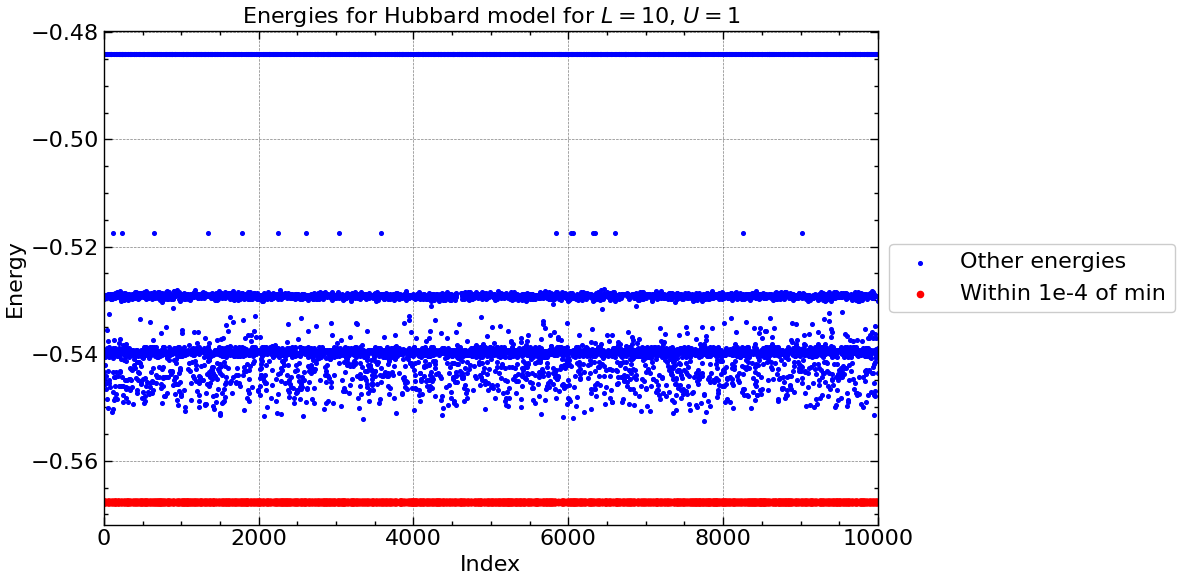

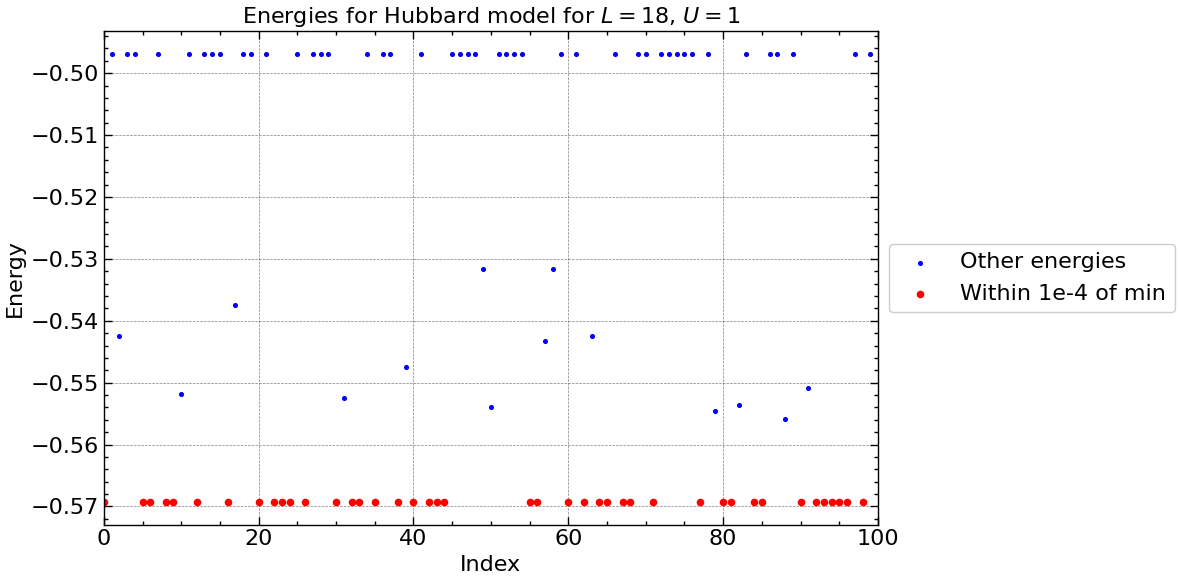

In [8]:
plot_energies(energies_8x8, L=8, U=1)
plot_energies(energies_10x10, L=10, U=1)
plot_energies(energies_18x18, L=18, U=1)